Import all required python modules.

In [1]:
import cf_units
import cftime

In [2]:
import iris
import ncdata
import numpy as np
import xarray as xr

In [3]:
from pathlib import Path

In [4]:
import matplotlib.pyplot as plt
import iris.quickplot as qplt

In [5]:
from ncdata.iris_xarray import cubes_to_xarray, cubes_from_xarray

In [6]:
iris.FUTURE.date_microseconds = True

In [7]:
iris.FUTURE.save_split_attrs = True

Load the grid mask data to use to regrid the ozone data.

In [8]:
esm_grid_mask_filepath = Path('/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/grids/global.N96/2020.05.19/qrparm.mask')

In [9]:
grid_cube = iris.load_cube(esm_grid_mask_filepath)
grid_cube.coord("latitude").guess_bounds()
grid_cube.coord("longitude").guess_bounds()

In [10]:
lat_points = grid_cube.coord("latitude").points
lon_points = grid_cube.coord("longitude").points

In [11]:
grid_coords = [("latitude", lat_points), ("longitude", lon_points)]

Load the ozone forcing data.

In [12]:
cmip7_pi_ozone_filepath = Path('/g/data/qv56/replicas/input4MIPs/CMIP7/CMIP/FZJ/FZJ-CMIP-ozone-1-2/atmos/monC/vmro3/gn/v20251010/vmro3_input4MIPs_ozone_CMIP_FZJ-CMIP-ozone-1-2_gn_185001-185012-clim.nc')

In [13]:
orig_ozone_cube = iris.load_cube(cmip7_pi_ozone_filepath)

In [14]:
orig_ozone_cube.coord('time').units

Unit('days since 1850-01-01', calendar='365_day')

Change the pressure units from hPa to Pa to match the available pressure data.

In [15]:
orig_ozone_cube.coord('air_pressure').convert_units('Pa')

Select one month of data: December 1850, to match the one month of available pressure data.

In [16]:
nov = cftime.DatetimeNoLeap(1850, 11, 30)

In [17]:
dec = iris.Constraint(time=lambda cell: cell.point > nov)

In [18]:
dec_ozone_cube = orig_ozone_cube.extract(dec)

In [19]:
dec_ozone_cube.remove_coord('time')

Interpolate the December ozone cube to the grid coordinates used by ESM1.6.

In [20]:
ozone_cube = dec_ozone_cube.interpolate(grid_coords, iris.analysis.Linear())

Plot the ozone data at each pressure level

In [21]:
ozone_cube_pressures = ozone_cube.coord('air_pressure').points

In [22]:
pressure_constraint = lambda index: iris.Constraint(air_pressure=ozone_cube_pressures[index])

In [23]:
cube_at_index = lambda index: ozone_cube.extract(pressure_constraint(index))

level: 1, air pressure: 100000.0


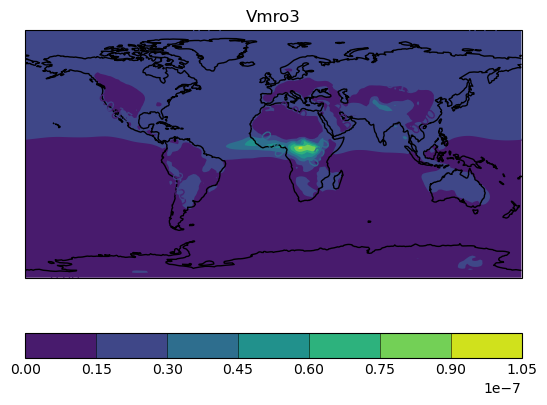

level: 11, air pressure: 45000.0


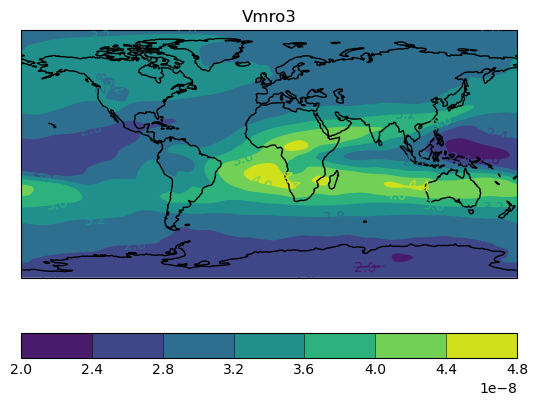

level: 21, air pressure: 11500.0


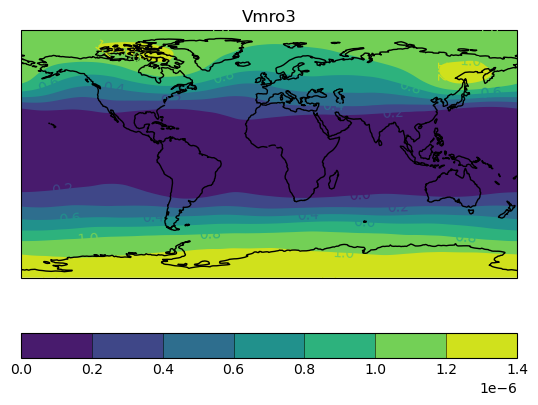

level: 31, air pressure: 2500.0


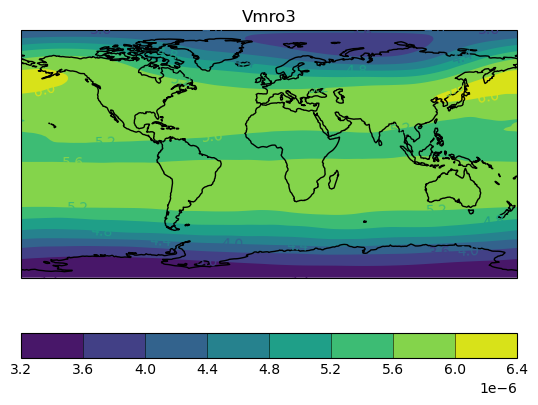

level: 41, air pressure: 100.0


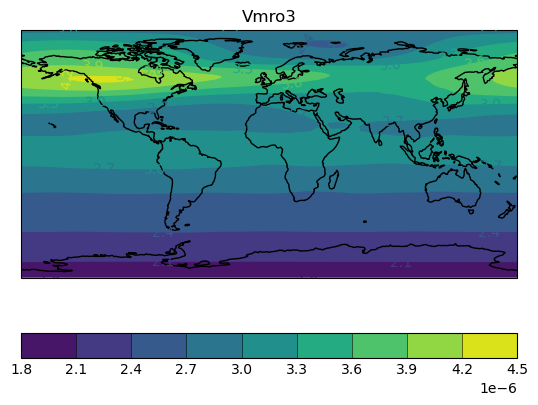

level: 51, air pressure: 4.0


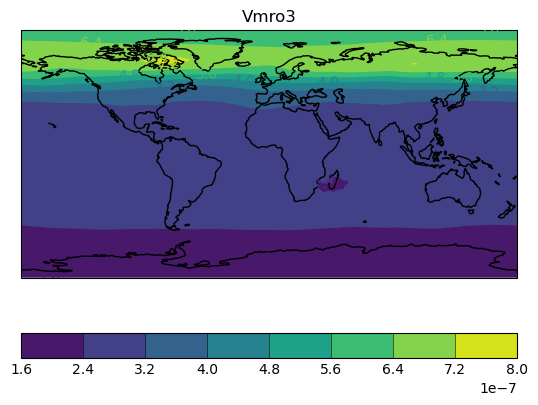

level: 61, air pressure: 0.15


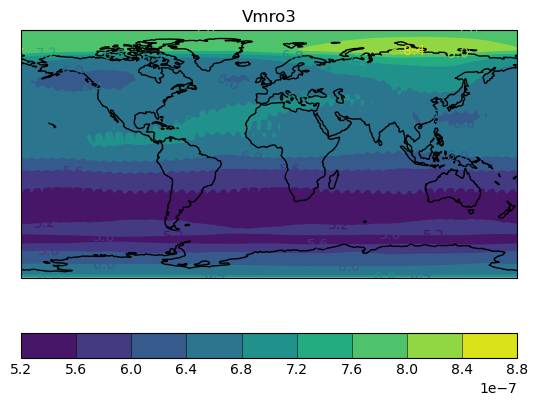

In [24]:
for n in range(0, len(ozone_cube_pressures), 10):
    level = n+1
    pressure = cube_at_index(n).coord('air_pressure').points[0]
    print(f'level: {level}, air pressure: {pressure}')
    # Add a filled contour, and put the result in a variable called contour.
    contour = qplt.contourf(cube_at_index(n))

    # Add coastlines to the map created by contour.
    plt.gca().coastlines()
    
    # Add contour labels based on the contour we have just created.
    plt.clabel(contour, inline=False)

    plt.show()

Convert the ozone cube to an XArray DataSet

In [25]:
ozone_ds = cubes_to_xarray(ozone_cube)

Rename the air pressure coordinate to 'air_pressure'

In [26]:
ozone_ds = ozone_ds.rename({'plev': 'air_pressure'})

Obtain the pressure data from a spinup file for December 2091.

In [27]:
spinup_filepath = Path('/g/data/p73/archive/CMIP7/ACCESS-ESM1-6/spinup/June2025/output999/atmosphere/netCDF/aiihca.pa-209112_mon.nc')

In [28]:
spinup_cube = iris.load(spinup_filepath)

In [29]:
pressure_index = 94

In [30]:
pressure_cube = spinup_cube[pressure_index]

Remove the time coordinate because only one month's data is being used.

In [31]:
pressure_cube

<iris 'Cube' of air_pressure / (Pa) (time: 1; model_level_number: 38; latitude: 145; longitude: 192)>

In [32]:
pressure_cube.remove_coord('time')

Convert the pressure cube to an XArray Dataset

In [33]:
pressure_ds = cubes_to_xarray(pressure_cube).squeeze()

In [34]:
pressure_ds

<xarray.Dataset> Size: 4MB
Dimensions:                 (model_rho_level_number: 38, lat: 145, lon: 192,
                             bnds: 2)
Coordinates:
  * model_rho_level_number  (model_rho_level_number) int32 152B 1 2 3 ... 37 38
  * lat                     (lat) float64 1kB -90.0 -88.75 -87.5 ... 88.75 90.0
  * lon                     (lon) float64 2kB 0.0 1.875 3.75 ... 356.2 358.1
    rho_level_height        (model_rho_level_number) float64 304B dask.array<chunksize=(38,), meta=numpy.ma.core.MaskedArray>
    sigma_rho               (model_rho_level_number) float64 304B dask.array<chunksize=(38,), meta=numpy.ma.core.MaskedArray>
    surface_altitude        (lat, lon) float64 223kB dask.array<chunksize=(145, 192), meta=numpy.ma.core.MaskedArray>
Dimensions without coordinates: bnds
Data variables:
    fld_s00i407             (model_rho_level_number, lat, lon) float32 4MB dask.array<chunksize=(38, 145, 192), meta=numpy.ma.core.MaskedArray>
    latitude_longitude      int32 4B dask.array<chunksize=(), meta=numpy.ma.core.MaskedArray>
    lat_bnds                (lat, bnds) float64 2kB dask.array<chunksize=(145, 2), meta=np.ndarray>
    lon_bnds                (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    rho_level_height_bnds   (model_rho_level_number, bnds) float64 608B dask.array<chunksize=(38, 2), meta=numpy.ma.core.MaskedArray>
    sigma_rho_bnds          (model_rho_level_number, bnds) float64 608B dask.array<chunksize=(38, 2), meta=numpy.ma.core.MaskedArray>
Attributes:
    Conventions:  CF-1.7
    history:      File /scratch/p66/jxs599/access-esm/archive/JuneSpinUp-June...
    source:       Data from Met Office Unified Model
    um_version:   7.3

Identify the ozone concentration variable

In [35]:
ozone_var = 'vmro3'

The target 'lat' and 'lon' values are the existing coordinates in pressure_ds.

In [36]:
target_lat = pressure_ds['lat']
target_lon = pressure_ds['lon']

The target 'air_pressure' values are the 'fld_s00i407' Data Variable in pressure_ds, temporarily renamed to 'air_pressure'

In [37]:
target_pressure = pressure_ds['fld_s00i407'].rename('air_pressure')

Extrapolate the ozone air_pressure coordinate from 1.0e5 to 1.1e5 to allow for the full range of possible surface air pressures.

In [38]:
ozone_air_pressure = ozone_ds['air_pressure'].data

In [39]:
ozone_air_pressure_newmax = (ozone_air_pressure.max() * 1.1)

In [40]:
ozone_air_pressure_ext = np.insert(ozone_air_pressure, 0, ozone_air_pressure_newmax)

In [41]:
ozone_ds_ext = ozone_ds.interp(air_pressure=ozone_air_pressure_ext, kwargs={"fill_value": "extrapolate"})

In [42]:
ozone_ds_ext

<xarray.Dataset> Size: 7MB
Dimensions:       (air_pressure: 67, lat: 145, lon: 192, bnds: 2)
Coordinates:
  * lat           (lat) float32 580B -90.0 -88.75 -87.5 ... 87.5 88.75 90.0
  * lon           (lon) float32 768B 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * air_pressure  (air_pressure) float64 536B 1.1e+05 1e+05 ... 0.03 0.01
Dimensions without coordinates: bnds
Data variables:
    vmro3         (air_pressure, lat, lon) float32 7MB dask.array<chunksize=(67, 145, 192), meta=numpy.ma.core.MaskedArray>
    plev_bnds     (air_pressure, bnds) float64 1kB dask.array<chunksize=(67, 2), meta=np.ndarray>
Attributes: (12/32)
    Conventions:          CF-1.7
    NCO:                  netCDF Operators version 5.3.5 (Homepage = http://n...
    activity_id:          input4MIPs
    comment:              CMIP7 pi-control ozone forcing climatology averaged...
    contact:              Michaela Hegglin (m.i.hegglin@fz-juelich.de); Dougl...
    creation_date:        2025-10-10T12:25:04Z
    ...                   ...
    source_id:            FZJ-CMIP-ozone-1-2
    source_version:       1.2
    target_mip:           CMIP
    title:                Ozone forcing v1.2 dataset (FZJ-CMIP-1-2) prepared ...
    tracking_id:          hdl:21.14100/6023d9be-0376-47be-957d-252c01c183f3
    variable_id:          vmro3

Use the kwargs syntax for unstructured interpolation

In [43]:
target_points = {
    'lat': target_lat,
    'lon': target_lon,
    'air_pressure': target_pressure
}

Perform the interpolation

In [44]:
ozone_at_level = ozone_ds_ext[ozone_var].interp(
    **target_points,
    method='linear'
)

In [45]:
ozone_at_level

<xarray.DataArray 'vmro3' (model_rho_level_number: 38, lat: 145, lon: 192)> Size: 4MB
dask.array<transpose, shape=(38, 145, 192), dtype=float32, chunksize=(38, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat                     (lat) float64 1kB -90.0 -88.75 -87.5 ... 88.75 90.0
  * lon                     (lon) float64 2kB 0.0 1.875 3.75 ... 356.2 358.1
    air_pressure            (model_rho_level_number, lat, lon) float32 4MB dask.array<chunksize=(38, 145, 192), meta=numpy.ma.core.MaskedArray>
  * model_rho_level_number  (model_rho_level_number) int32 152B 1 2 3 ... 37 38
    rho_level_height        (model_rho_level_number) float64 304B dask.array<chunksize=(38,), meta=numpy.ma.core.MaskedArray>
    sigma_rho               (model_rho_level_number) float64 304B dask.array<chunksize=(38,), meta=numpy.ma.core.MaskedArray>
    surface_altitude        (lat, lon) float64 223kB dask.array<chunksize=(145, 192), meta=numpy.ma.core.MaskedArray>
Attributes:
    long_name:     vmro3
    units:         moles mole-1
    cell_methods:  time: mean

Merge the results

In [46]:
ozone_at_level_ds = pressure_ds.merge(ozone_at_level)

In [47]:
ozone_at_level_cubelist = cubes_from_xarray(ozone_at_level_ds)

In [48]:
ozone_at_level_cubelist

[<iris 'Cube' of vmro3 / (moles mole-1) (model_level_number: 38; latitude: 145; longitude: 192)>,
<iris 'Cube' of air_pressure / (Pa) (model_level_number: 38; latitude: 145; longitude: 192)>,
<iris 'Cube' of surface_altitude / (m) (latitude: 145; longitude: 192)>]

In [49]:
[cube.name() for cube in ozone_at_level_cubelist]

['vmro3', 'air_pressure', 'surface_altitude']

In [50]:
ozone_constraint = iris.Constraint(name=ozone_var)

In [51]:
ozone_ancil_cube = ozone_at_level_cubelist.extract_cube(ozone_constraint)

In [52]:
ozone_ancil_cube

<iris 'Cube' of vmro3 / (moles mole-1) (model_level_number: 38; latitude: 145; longitude: 192)>

In [53]:
level_constraint = lambda level: iris.Constraint(model_level_number=level)

In [54]:
cube_at_level = lambda level: ozone_ancil_cube.extract(level_constraint(level))

model_level_number: 1, hybrid_height: 9.9982


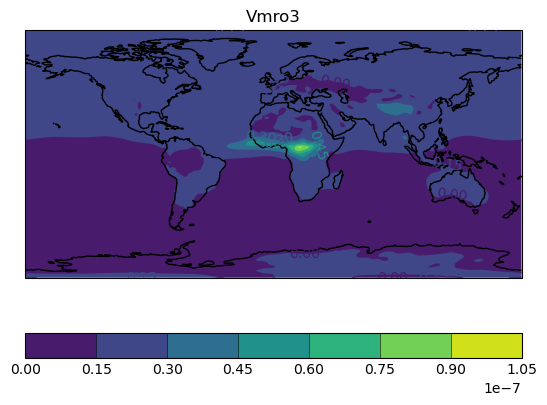

model_level_number: 2, hybrid_height: 49.999


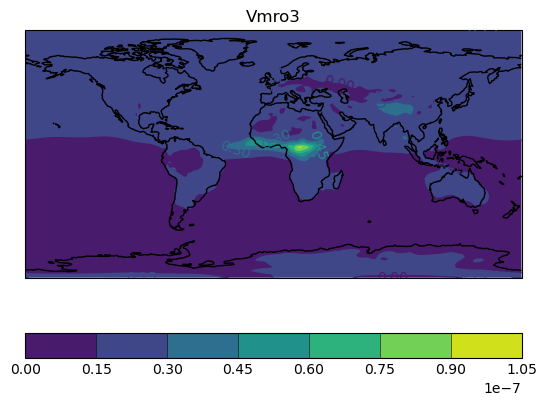

model_level_number: 3, hybrid_height: 130


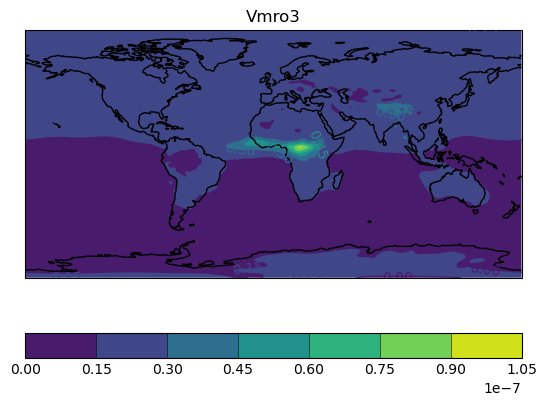

model_level_number: 4, hybrid_height: 250


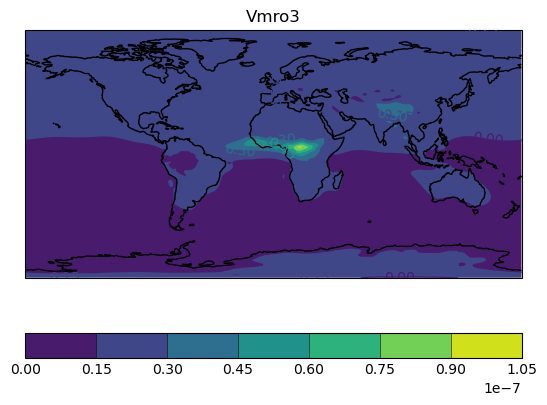

model_level_number: 5, hybrid_height: 410


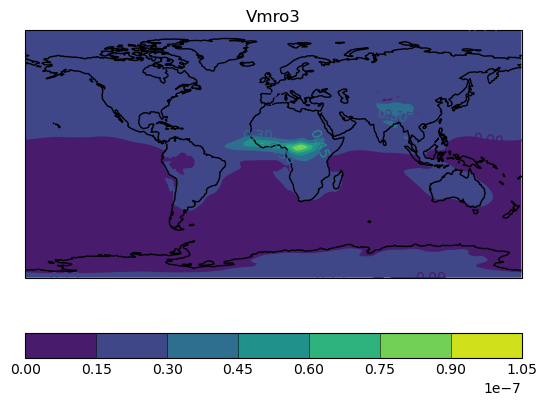

model_level_number: 6, hybrid_height: 610


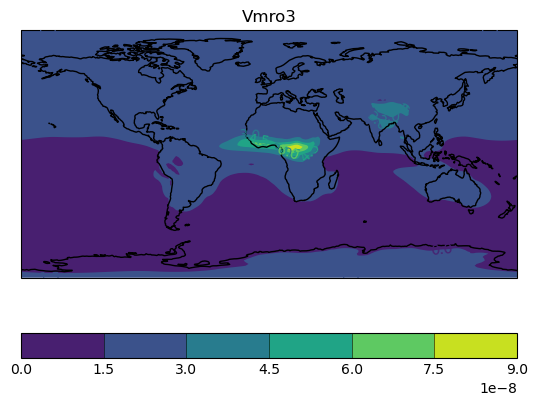

model_level_number: 7, hybrid_height: 850


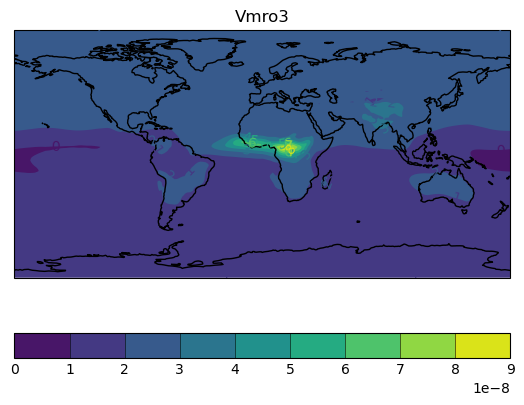

model_level_number: 8, hybrid_height: 1130


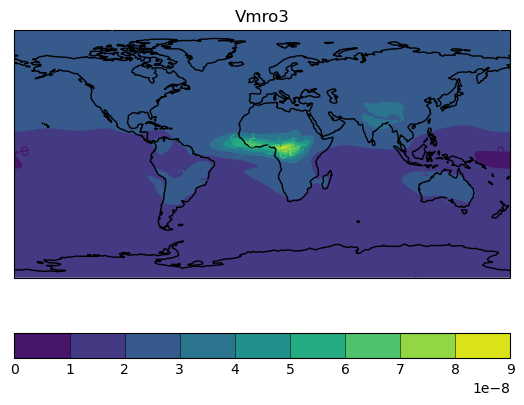

model_level_number: 9, hybrid_height: 1450


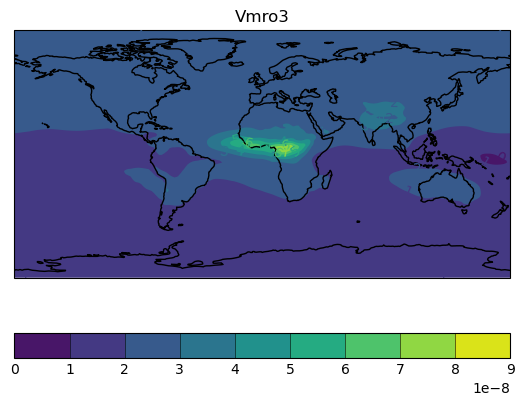

model_level_number: 10, hybrid_height: 1810


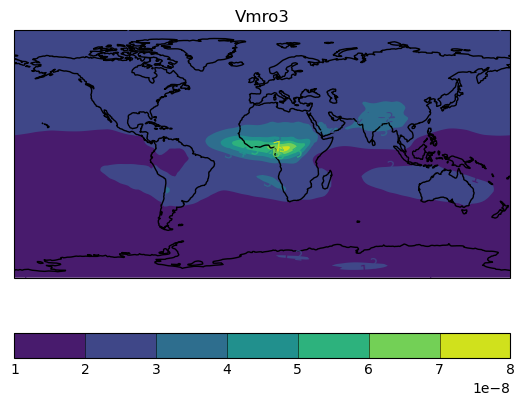

model_level_number: 11, hybrid_height: 2210


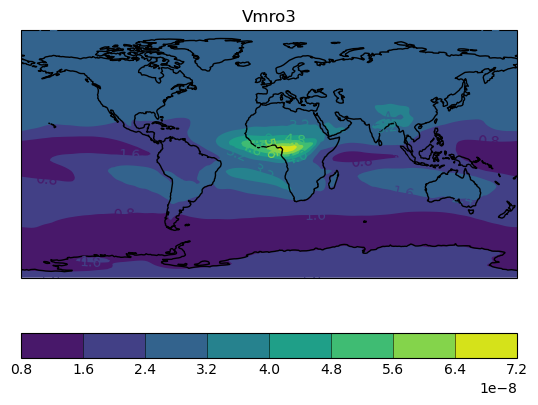

model_level_number: 12, hybrid_height: 2650


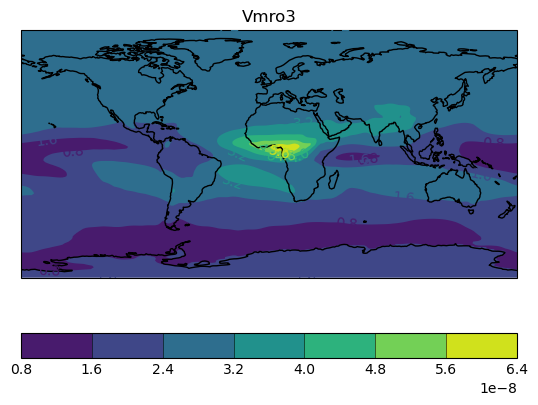

model_level_number: 13, hybrid_height: 3130


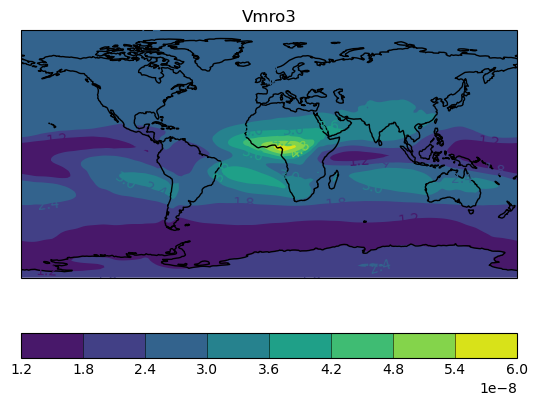

model_level_number: 14, hybrid_height: 3650


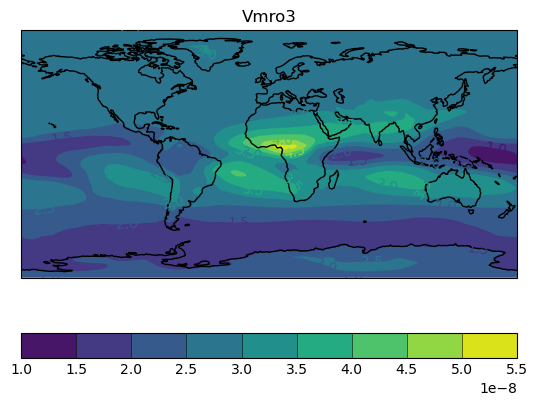

model_level_number: 15, hybrid_height: 4210


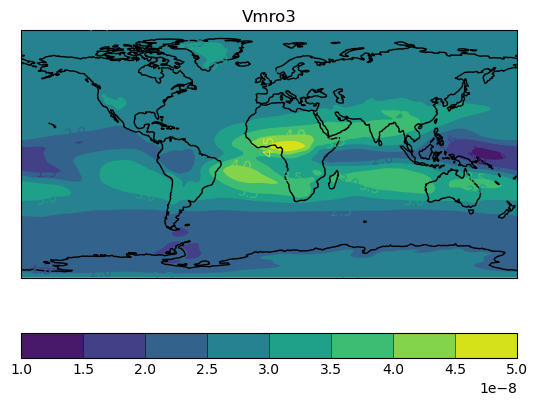

model_level_number: 16, hybrid_height: 4810


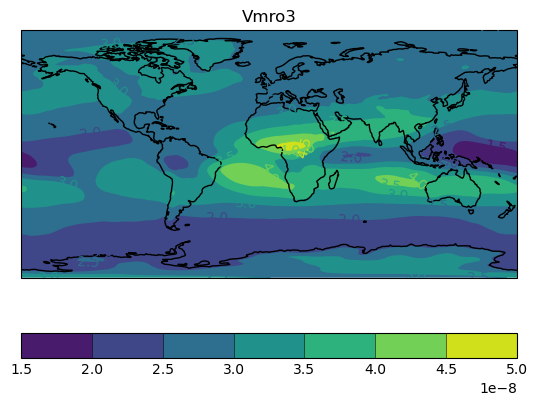

model_level_number: 17, hybrid_height: 5450


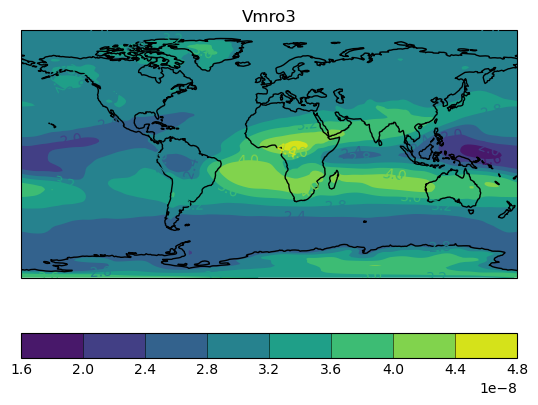

model_level_number: 18, hybrid_height: 6130


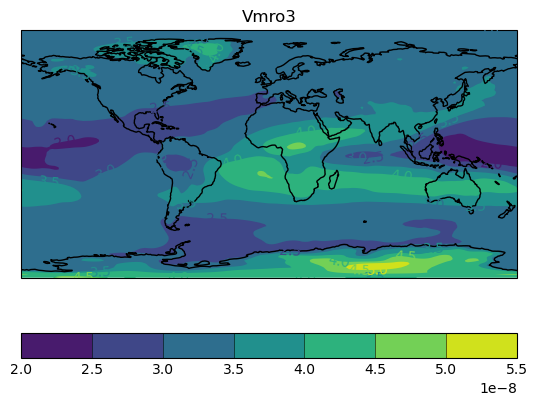

model_level_number: 19, hybrid_height: 6850


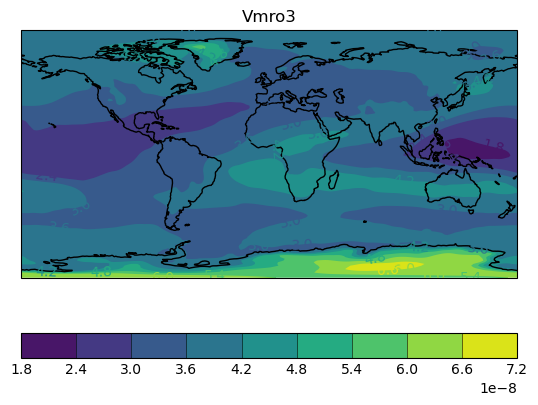

model_level_number: 20, hybrid_height: 7610


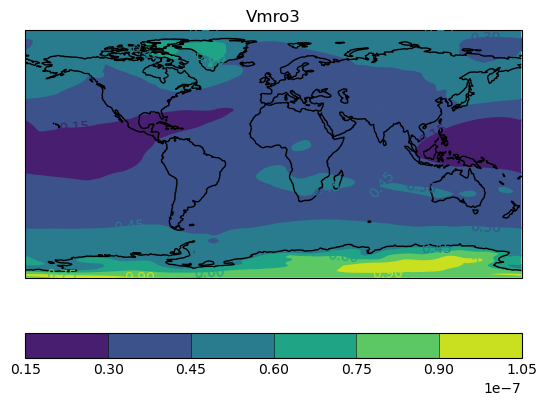

model_level_number: 21, hybrid_height: 8410


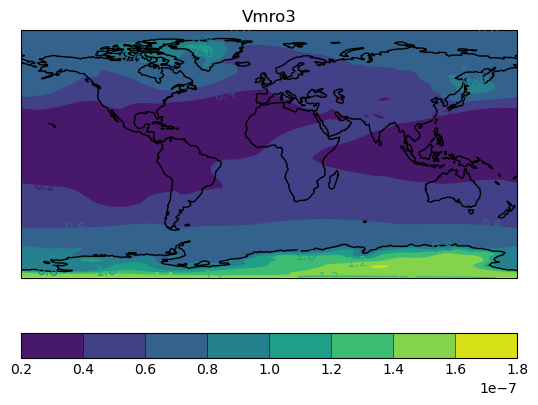

model_level_number: 22, hybrid_height: 9250


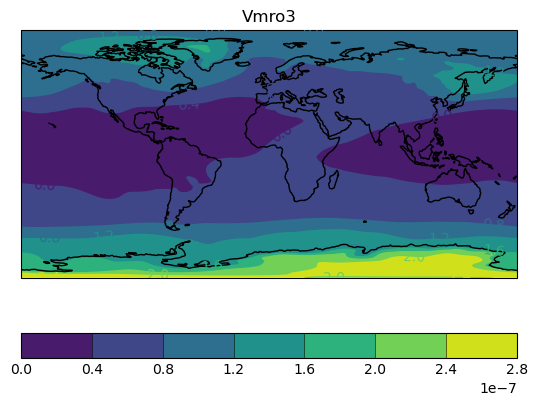

model_level_number: 23, hybrid_height: 10130


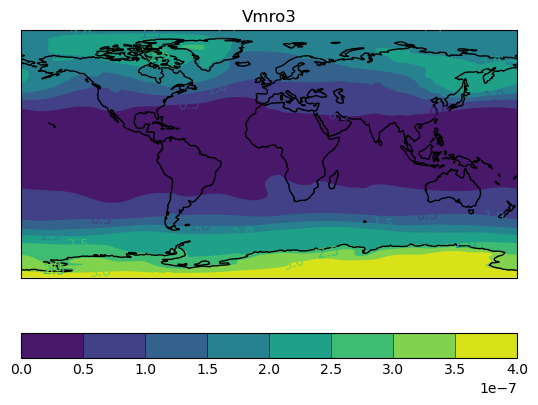

model_level_number: 24, hybrid_height: 11050


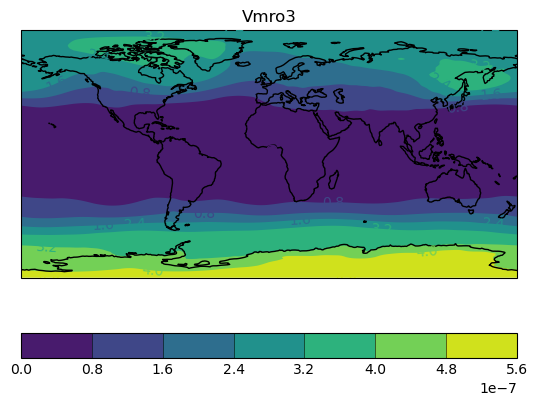

model_level_number: 25, hybrid_height: 12010


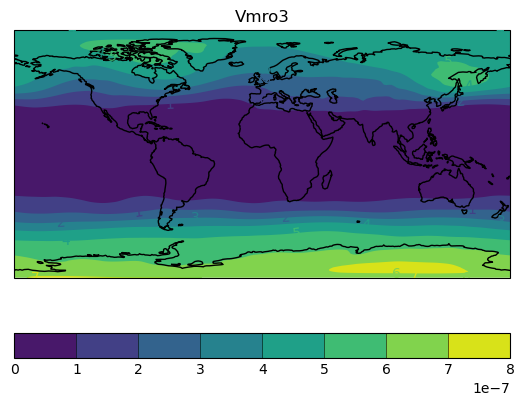

model_level_number: 26, hybrid_height: 13010


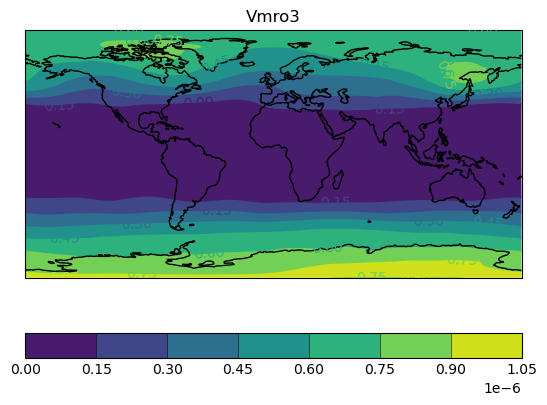

model_level_number: 27, hybrid_height: 14050


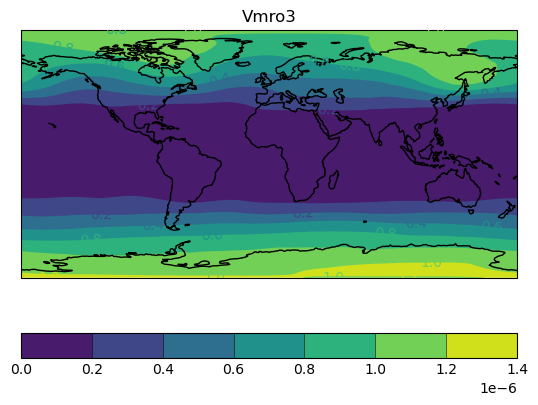

model_level_number: 28, hybrid_height: 15138


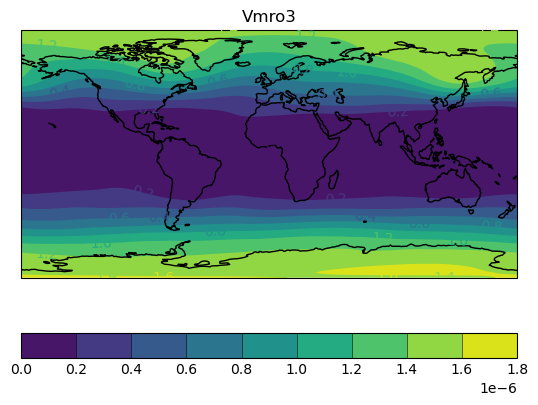

model_level_number: 29, hybrid_height: 16285


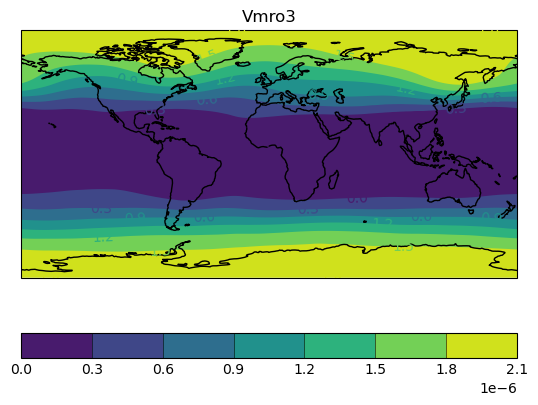

model_level_number: 30, hybrid_height: 17507


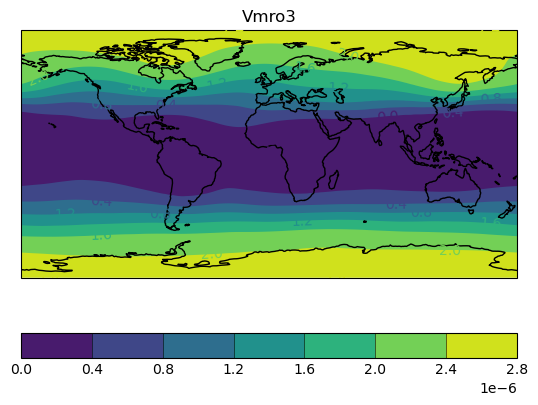

model_level_number: 31, hybrid_height: 18821


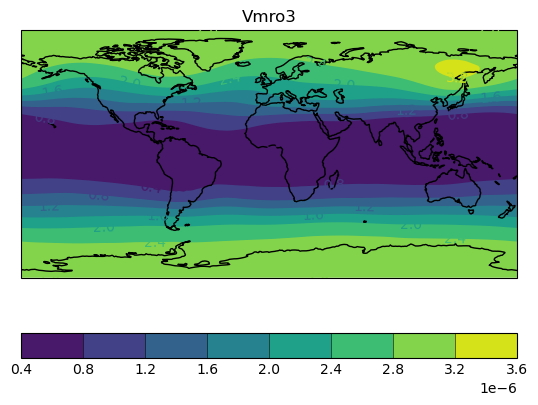

model_level_number: 32, hybrid_height: 20247


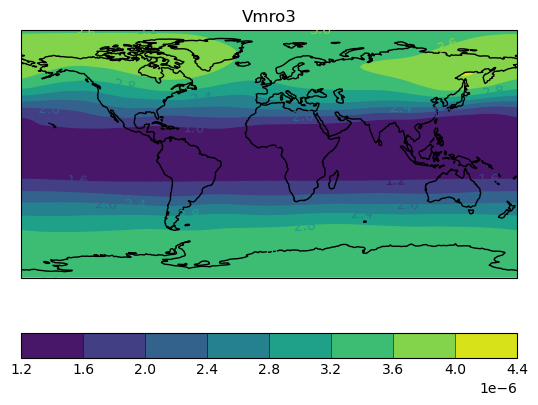

model_level_number: 33, hybrid_height: 21808


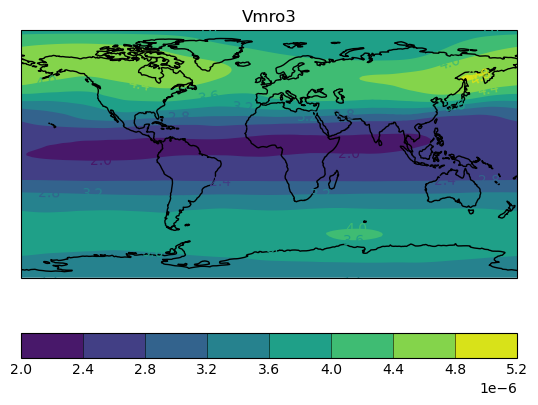

model_level_number: 34, hybrid_height: 23542


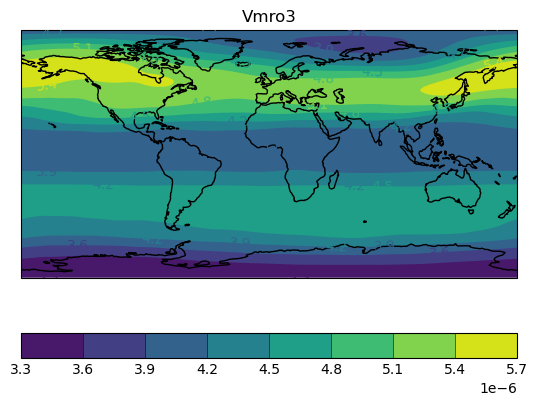

model_level_number: 35, hybrid_height: 25521


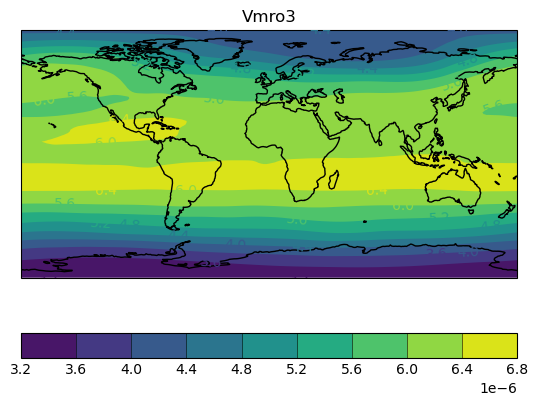

model_level_number: 36, hybrid_height: 27901


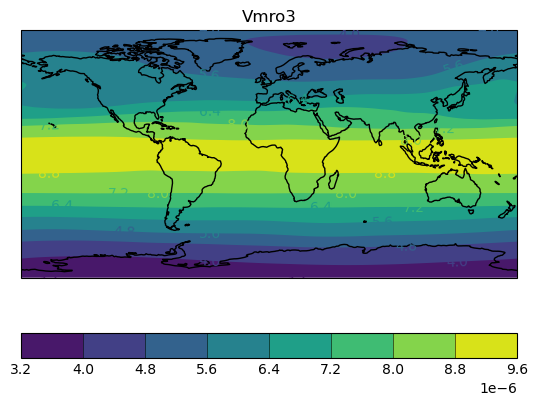

model_level_number: 37, hybrid_height: 31064


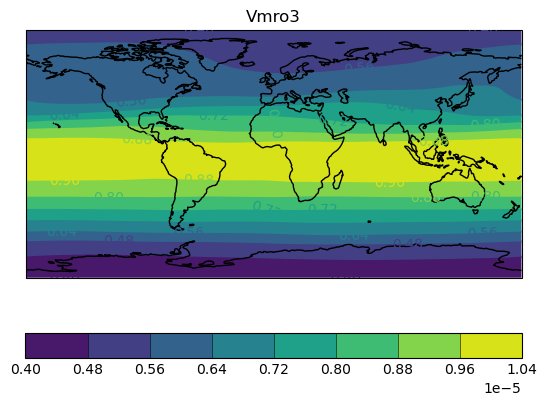

model_level_number: 38, hybrid_height: 36082


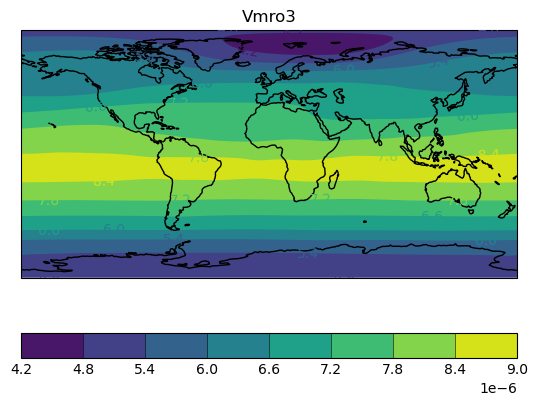

In [55]:
for n in range(38):
    level = n+1
    height = cube_at_level(level).coord('atmosphere_hybrid_height_coordinate').points[0]
    print(f'model_level_number: {level}, hybrid_height: {height:.5g}', )
    # Add a filled contour, and put the result in a variable called contour.
    contour = qplt.contourf(cube_at_level(level))

    # Add coastlines to the map created by contour.
    plt.gca().coastlines()
    
    # Add contour labels based on the contour we have just created.
    plt.clabel(contour, inline=False)

    plt.show()

The air pressure extrapolation prevents missing data at the lowest hybrid height levels